In [554]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import stats
import re

class RegexDict(dict):

    def get_matching(self, event):
        for key in self:
            if re.match(key,event):
                return self[key]


In [555]:
# %matplotlib widget 
%matplotlib inline

In [556]:
# dir_setup = '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_nrw_test'
dir_setup = '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test'

## Read and convert CLM data

In [557]:
fracdata = xr.load_dataset(os.path.join(dir_setup,'input/clm/fracdata_CLM_cordex0.11_436x424_cosmomask_varpft_noice.nc'))
griddata = xr.load_dataset(os.path.join(dir_setup,'input/clm/griddata_CLM_cordex0.11_436x424_cosmomask_varpft_noice.nc'))
surfdata_ = xr.load_dataset(os.path.join(dir_setup,'input/clm/surfdata_CLM_cordex0.11_436x424_cosmomask_varpft_noice.nc'))
topodata = xr.load_dataset(os.path.join(dir_setup,'input/clm/topodata_CLM_cordex0.11_436x424_cosmomask_varpft_noice.nc'))

# fracdata = xr.load_dataset(glob.glob(os.path.join(dir_setup,'input/clm/fracdata_*.nc'))[0] )
# griddata = xr.load_dataset(glob.glob(os.path.join(dir_setup,'input/clm/griddata_*.nc'))[0] )
# surfdata = xr.load_dataset(glob.glob(os.path.join(dir_setup,'input/clm/surfdata_*.nc'))[0] )
# topodata = xr.load_dataset(glob.glob(os.path.join(dir_setup,'input/clm/topodata_*.nc'))[0] )

surfdata = surfdata_.drop_vars('time')

n_coarse = 4

assert len(griddata['lsmlat']) % n_coarse == 0, 'Set n_coarse to integer value, splitting the domain into equal parts'
assert len(griddata['lsmlon']) % n_coarse == 0, 'Set n_coarse to integer value, splitting the domain into equal parts'


In [573]:
print(griddata['LONW'][0:2,0:2].values)
print(griddata['LONE'][0:3,0:3].values)
print(griddata['LATS'][0:3,0:3].values)
print(griddata['LATN'][0:3,0:3].values)
print(griddata['LONGXY'][0:2,0:2].values)

print(griddata['LONW'][1:,0] - griddata['LONW'][:-1,0])
print(griddata['LONW'][0,1:] - griddata['LONW'][0,:-1])
griddata

[[-10.42270803 -10.32412195]
 [-10.47033119 -10.37160683]]
[[-10.32412195 -10.22544813 -10.12668657]
 [-10.37160683 -10.27279472 -10.17389441]
 [-10.41915751 -10.32020617 -10.22116613]]
[[21.09462929 21.13501358 21.17526913]
 [21.19530392 21.2357502  21.27606869]
 [21.29596615 21.33647442 21.3768549 ]]
[[21.19530392 21.2357502  21.27606869]
 [21.29596615 21.33647442 21.3768549 ]
 [21.39661503 21.43718529 21.47762775]]
[[-10.37343693 -10.27480698]
 [-10.42099094 -10.32222271]]
<xarray.DataArray 'LONW' (lsmlat: 423)>
array([-0.04762316, -0.04768896, -0.04775381, -0.04782057, -0.04788589,
       -0.04795265, -0.04802036, -0.0480876 , -0.04815578, -0.04822397,
       -0.04829264, -0.04836226, -0.04843187, -0.04850245, -0.04857254,
       -0.04864359, -0.04871511, -0.04878759, -0.04885912, -0.04893255,
       -0.04900551, -0.04907942, -0.0491538 , -0.04922819, -0.04930353,
       -0.04937935, -0.04945517, -0.04953146, -0.04960823, -0.04968596,
       -0.04976416, -0.04984283, -0.04992056, -

<xarray.Dataset>
Dimensions:   (lsmlat: 424, lsmlon: 436, ncl2: 1, ncl3: 1, ncl4: 1, ncl5: 1)
Dimensions without coordinates: lsmlat, lsmlon, ncl2, ncl3, ncl4, ncl5
Data variables: (12/13)
    NUMLON    (lsmlat) float64 436.0 436.0 436.0 436.0 ... 436.0 436.0 436.0
    LONGXY    (lsmlat, lsmlon) float64 -10.37 -10.27 -10.18 ... 67.03 67.23
    LATIXY    (lsmlat, lsmlon) float64 21.14 21.19 21.23 ... 66.95 66.89 66.83
    LONE      (lsmlat, lsmlon) float64 -10.32 -10.23 -10.13 ... 67.13 67.33
    LATN      (lsmlat, lsmlon) float64 21.2 21.24 21.28 ... 67.0 66.93 66.87
    LONW      (lsmlat, lsmlon) float64 -10.42 -10.32 -10.23 ... 66.93 67.13
    ...        ...
    AREA      (lsmlat, lsmlon) float64 156.2 156.2 156.2 ... 156.2 156.2 156.2
    LANDMASK  (lsmlat, lsmlon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    EDGEN     (ncl2) float64 67.73
    EDGEE     (ncl3) float64 37.53
    EDGES     (ncl4) float64 21.09
    EDGEW     (ncl5) float64 -10.43
Attributes:
    creation_date:  Do 31. Jul 16:33:46 CEST 2014
    Conventions:    None
    source_file:    jkeune
    title:          Synthetic Data for CLM3.5 on the CORDEX 0.11 domain

In [549]:
def div_n(x):
    x_ = x / n_coarse
    return x_[:,0]

def median_round(x,round_='up'):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    x_ = x.median(axis=(1,3))
    if round_ == 'down':
         #   x_[x_ < 1] = 0    
        mask = ~(x_<1) #everything smaller than 1 will get assigned sea
        x_ = x_.where(mask).fillna(0)

    elif round_ == 'up':
        # x_[x_ > 0] = 1
        mask = ~(x_ > 0) #everything larger than 0 will get assigned land
        x_ = x_.where(mask).fillna(1)
        
    return x_

def lower_corner(x):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    return x[:,0,:,0]

def upper_corner(x):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    return x[:,-1,:,-1]

def centre(x):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    i_take = int(n_coarse / 2)
    assert n_coarse%2 == 0
    return x[:,i_take,:,i_take]

def sum_cells(x):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    return x.sum(axis=(1,3))

def mean_cells(x):
    i_yfine = x.dims.index('y_fine')
    i_xfine = x.dims.index('x_fine')
    return x.mean(axis=(i_yfine,i_xfine))

def most_common(x):
    assert len(x.dims) == 4, 'TODO: implement fn for depth/time dimensions'
    vals = np.unique(x)

    grid_most_common = np.zeros([x.shape[0],x.shape[2]])
    grid_n_vals = np.zeros([x.shape[0],x.shape[2]])
    
    #initialize return dataset
    grid_return = x.median(axis=(1,3))
    
    #loop through each unique value, check number (n) of values per aggregated grid, set to new value if n is larger than previous
    for val_ in vals:
        mask_val = (x == val_)
        n_val = mask_val.sum(axis=(1,3)).values

        mask_apply = (n_val > grid_n_vals) #>: equal amounts -> favour smaller index; >=: equal amounts -> favour larger index
        grid_most_common[mask_apply] = val_
        grid_n_vals[mask_apply] = n_val[mask_apply]
        
    grid_return.values = grid_most_common
    return grid_return

dict_fn = RegexDict({'NUMLON':'div_n','LONGXY':'centre','LATIXY':'centre',
           'LANDMASK':'median_round','LANDFRAC':'median_round',
           'LONE':'upper_corner','LATN':'upper_corner','LONW':'lower_corner','LATS':'lower_corner',
           'AREA':'sum_cells','TOPO':'mean_cells','LANDFRAC_PFT':'median_round','PFTDATA_MASK':'median_round',
           'SOIL_COLOR':'most_common','PCT_(.*)':'mean_cells','MONTHLY_(.*)':'mean_cells'})

list_coarsen = [fracdata,griddata,topodata,surfdata]
dict_data_coarse = {'fracdata':None,'griddata':None,'topodata':None,'surfdata':None}

for data_,name_ in zip(list_coarsen,dict_data_coarse.keys()):

    print('coarsening %s' % name_)

    data_coarse = data_.coarsen(dim={'lsmlat':n_coarse,'lsmlon':n_coarse},boundary='exact').median()
    data_regions = data_.coarsen(dim={'lsmlat':n_coarse,'lsmlon':n_coarse},boundary='exact').construct(lsmlon=("lsmlon", "x_fine"), lsmlat=("lsmlat", "y_fine"))

    for var_ in data_regions.keys():

        fn_agg = dict_fn.get_matching(var_)    
        if fn_agg is not None:
            data_coarse[var_] = locals()[fn_agg](data_regions[var_])

    
    dict_data_coarse[name_] = data_coarse
    
dict_data_coarse['surfdata'] = dict_data_coarse['surfdata'].assign_coords(surfdata_.coords) #copy back the original time coordinates

coarsening fracdata
coarsening griddata
coarsening topodata
coarsening surfdata


In [553]:
dict_data_coarse['surfdata'] 

<xarray.Dataset>
Dimensions:             (lsmlat: 106, lsmlon: 109, nlevsoi: 10, lsmpft: 17, time: 12, ncl6: 1, ncl7: 1, ncl8: 1, ncl9: 1, ncl10: 1, ncl5: 12)
Coordinates:
    time                (ncl5) float64 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
Dimensions without coordinates: lsmlat, lsmlon, nlevsoi, lsmpft, ncl6, ncl7, ncl8, ncl9, ncl10, ncl5
Data variables: (12/29)
    NUMLON              (lsmlat) float64 109.0 109.0 109.0 ... 109.0 109.0 109.0
    LONGXY              (lsmlat, lsmlon) float64 -10.27 -9.874 ... 66.04 66.85
    LATIXY              (lsmlat, lsmlon) float64 21.43 21.59 ... 67.06 66.81
    LONE                (lsmlat, lsmlon) float64 -10.17 -9.771 ... 66.52 67.33
    LATN                (lsmlat, lsmlon) float64 21.62 21.78 ... 67.13 66.87
    LONW                (lsmlat, lsmlon) float64 -10.42 -10.03 ... 65.18 66.0
    ...                  ...
    MONTHLY_HEIGHT_BOT  (time, lsmpft, lsmlat, lsmlon) float32 nan nan ... nan
    mxsoil_color        (ncl6) int32 20
    EDGEN               (ncl7) float64 67.73
    EDGEE               (ncl8) float64 37.53
    EDGES               (ncl9) float64 21.09
    EDGEW               (ncl10) float64 -10.43
Attributes:
    creation_date:  Do 31. Jul 16:33:47 CEST 2014
    Conventions:    None
    source_file:    jkeune
    title:          Synthetic Data for CLM3.5 on the CORDEX 0.11 domain

array([0., 1.])

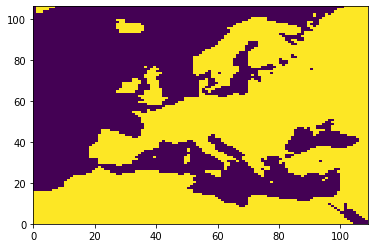

In [372]:
x_ = data_regions[var_].median(axis=(1,3)) 

# mask = ~(x_ > 0) everything larger than 0 will get assigned land
mask = ~(x_<1) #everything smaller than 1 will get assigned sea

# x_ = data_regions[var_].median(axis=(1,3))
# x_ = x_.where(x_>0).fillna(0)
# np.unique(x_)# x_
# mask.fillna(0)

# plt.figure()
# plt.pcolormesh(mask)

# mask = x_ < 1
# mask.fillna(0)
# plt.figure()
# plt.pcolormesh(mask)

x_ = x_.where(mask).fillna(1)
x_ = x_.where(mask).fillna(0)

plt.figure()
plt.pcolormesh(x_)

np.unique(x_)
# x_

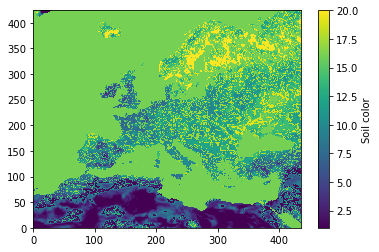

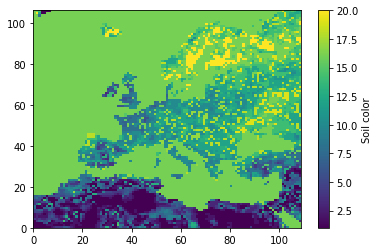

In [283]:
data_ = surfdata_.copy()
x = data_regions['SOIL_COLOR']

vals = np.unique(x)

grid_most_common = np.zeros([x.shape[0],x.shape[2]])
grid_n_vals = np.zeros([x.shape[0],x.shape[2]])

#loop through each unique value, check number (n) of values per aggregated grid, set to new value if n is larger than previous
for val_ in vals:
    mask_val = (x == val_)
    n_val = mask_val.sum(axis=(1,3)).values
    
    mask_apply = (n_val > grid_n_vals) #>: equal amounts -> favour smaller index; >=: equal amounts -> favour larger index
    grid_most_common[mask_apply] = val_
    grid_n_vals[mask_apply] = n_val[mask_apply]
    
plt.figure()
plt.pcolormesh(data_['SOIL_COLOR'])
plt.colorbar(label='Soil color')

plt.figure()
plt.pcolormesh(grid_most_common)  
plt.colorbar(label='Soil color')


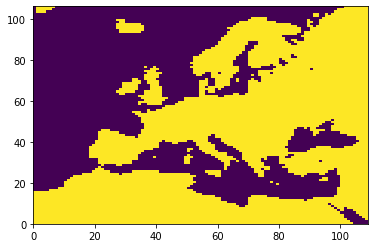

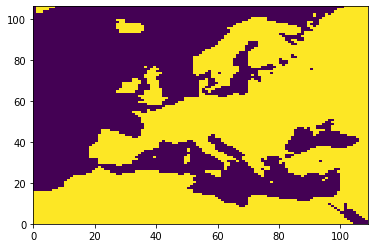

In [379]:
m1 = median_round(data_regions['LANDMASK'],round_='up')
m2 = median_round(data_regions['LANDMASK'],round_='down')

plt.figure()
plt.pcolormesh(m1)

plt.figure()
plt.pcolormesh(m2)

In [ ]:

#TODO: use the count function in case of e.g. multiple PFT's to assign one value to a gridcell
(data_regions['LANDMASK']==1).count(dim=['x_fine','y_fine'])


# regions['LANDMASK'].mean(axis=(1,3))
# print(regions['LONW'][-1,:,-1,:])
# test_lon1 = fracdata['LONW'][::4,::4]


# # test_lon2 = xr.apply_ufunc(mean_per_box, regions['LONW'],input_core_dims=('x_coarse','x_fine','y_coarse','y_fine'),output_core_dims=('x_coarse','y_coarse'))

# lower_corner(regions['LONW'])
# regions['LANDFRAC'].mean(axis=(1,3)).shape
# centre(regions['LONGXY'])
# lower_corner(regions['LONW'])

# for var_ in apply_fn.keys():
#     data_coarse[var_] = locals()[apply_fn[var_]](data_regions[var_])
    
# mode_ = lambda x: stats.mode(x)[0][0]  

def mode_(x,axis=0):
    
    return stats.mode(x)[0][0]
# a = stats.mode( regions['LANDMASK'][0,:,0,:].values.ravel() , axis=(0))

# np.apply_over_axes(mode_, regions['LANDMASK'].values, axes=[0,2]).shape
# data_regions['LANDMASK'].reduce(mode_,axis=(1,3))



# stats.mode(regions['LANDMASK'], axis=1)[1].shape
# centre(data_regions[var_])
# data_coarse['NUMLON'].shape
# stats.mode(regions['LANDMASK'],axis=[1,3] )
# np.unique(regions['LANDMASK'], return_counts=True, axis=(1))[0].shape
# values, counts = np.unique(regions['LANDMASK'], return_counts=True, axis=(1,3))
# values

# mode_(regions['LANDMASK'].values, axis=0)

plt.figure()
plt.pcolormesh(median_round(regions['LANDMASK'],round_='down'))

plt.figure()
plt.pcolormesh(median_round(regions['LANDMASK'],round_='up'))

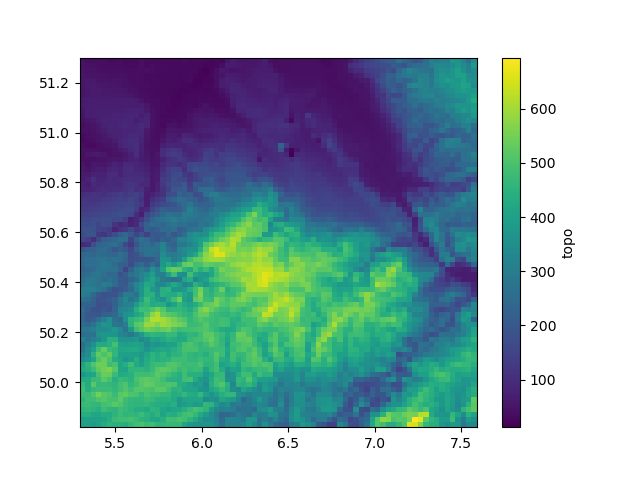

In [113]:
plt.figure()
plt.pcolormesh(topodata_coarse['LONGXY'],topodata_coarse['LATIXY'],topodata_coarse['TOPO'][:-1,:-1])
plt.colorbar(label='topo')

In [55]:
#example selection of data
#np.nanmin(topodata['TOPO'].where(fracdata['LANDMASK']==1).values)
np.median([0,1])

0.5

/tmp/ipykernel_12664/914609473.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


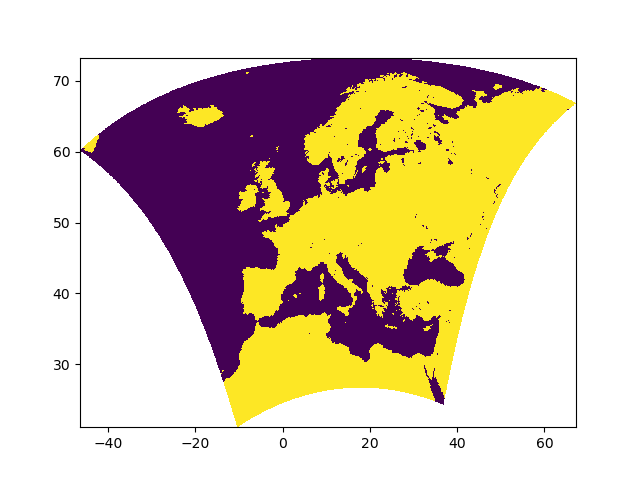

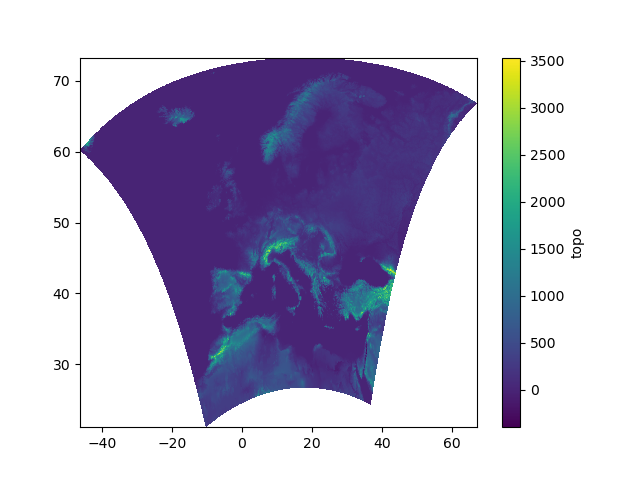

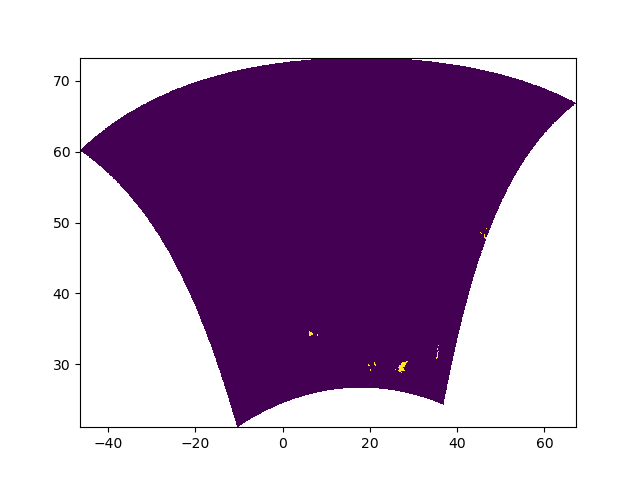

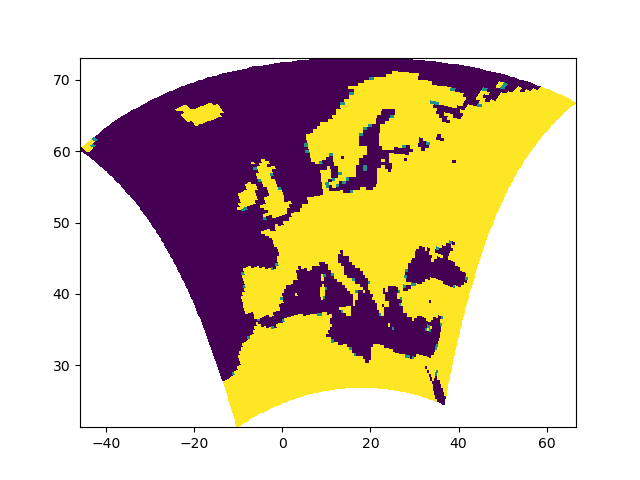

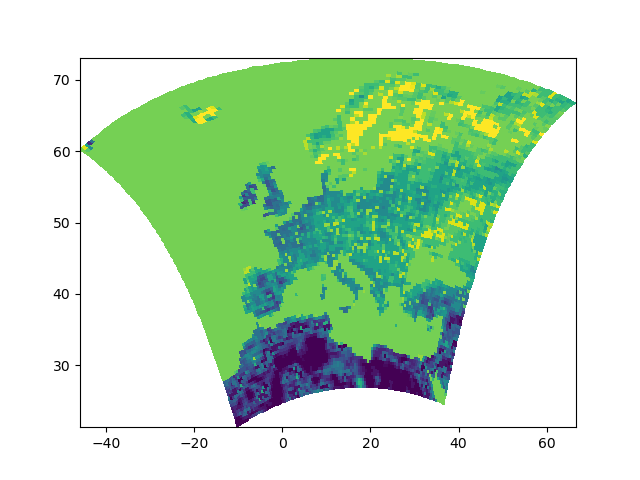

In [52]:
plt.figure()
plt.pcolormesh(fracdata['LONGXY'],fracdata['LATIXY'],fracdata['LANDMASK'][:-1,:-1])

plt.figure()
plt.pcolormesh(fracdata['LONGXY'],fracdata['LATIXY'],topodata['TOPO'][:-1,:-1])
plt.colorbar(label='topo')

plt.figure()
plt.pcolormesh(fracdata['LONGXY'],fracdata['LATIXY'],(topodata['TOPO'][:-1,:-1]<-10))

plt.figure()
plt.pcolormesh(fracdata_coarse['LONGXY'],fracdata_coarse['LATIXY'],(fracdata_coarse['LANDMASK'][:-1,:-1]))

plt.figure()
plt.pcolormesh(fracdata_coarse['LONGXY'],fracdata_coarse['LATIXY'],(surfdata_coarse['SOIL_COLOR'][:-1,:-1]))
